In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

/home/dulab/anaconda3/envs/pythonProject1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=224, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),    
        transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/dulab/Downloads/transfer_learning/alexnet_test5classes/data'

train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
# test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=32, shuffle=True, num_workers=4)
# test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

class_names = train_datasets.classes

In [4]:
train_datasets

Dataset ImageFolder
    Number of datapoints: 3046
    Root location: /home/dulab/Downloads/transfer_learning/alexnet_test5classes/data/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
               RandomPerspective(p=0.5)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
val_datasets

Dataset ImageFolder
    Number of datapoints: 524
    Root location: /home/dulab/Downloads/transfer_learning/alexnet_test5classes/data/val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
def evaluation(model, dataloader):
    model.eval()
    dataset_size = len(dataloader.dataset)
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return epoch_acc, epoch_loss

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    val_epoch_acc = 0 
    train_dataset_size = len(train_dataloader.dataset)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
   
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        running_loss = 0.0
        running_corrects = 0
        i = 0
            
        model.train() 
        # Iterate over data during the training stage.
        for inputs, labels in train_dataloader:
            i = i+1
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize  phase
                loss.backward()
                optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
        scheduler.step()
                
        train_epoch_loss = running_loss / train_dataset_size
        train_loss.append(train_epoch_loss)
        train_epoch_acc = running_corrects.double() / train_dataset_size
        train_acc.append(train_epoch_acc.item())
        print(f'Train loss: {train_epoch_loss:.4f} Training_acc: {train_epoch_acc:.4f}')
        
        val_since = time.time()
        val_epoch_acc, val_epoch_loss = evaluation(model, val_dataloader)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc.item())
        val_time = time.time() - val_since
        print(f'Val complete in {val_time:4f} seconds.')
        print(f'Val loss: {val_epoch_loss:.4f} Val acc: {val_epoch_acc:.4f}')
        
        # deep copy the model
        if  val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(i)

    time_elapsed = time.time() - since
    print(f'Training and validation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.4f}s')
    print(f'Best Val Acc: {best_val_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc

In [8]:
def loss_plot(train_loss, val_loss, index, epoch_num, lr):
    x = np.arange(epoch_num)
    plt.plot(x, train_loss, 'r-+', label='Train loss')
    plt.plot(x, val_loss, 'b-o', label='Val loss')  
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    title = 'Train and val loss with ' + str(index) + ' layer(s) locked and learning rate set to ' + str(lr)
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
def acc_plot(train_acc, val_acc, index, epoch_num, lr):
    x = np.arange(epoch_num)
    plt.plot(x, train_acc, 'r-+', label='Train acc')
    plt.plot(x, val_acc, 'b-o', label='Val acc')  
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    title = 'Train and val acc with ' + str(index) + ' layer(s) locked and learning rate set to ' + str(lr)
    plt.title(title)
    plt.legend()
    plt.show()

In [10]:
best_test_acc_list = []
epoch_num = 30
criterion = nn.CrossEntropyLoss()

In [11]:
learning_rate = [1e-4, 5e-5, 3e-5, 1e-5, 5e-6, 1e-6]
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

In [12]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[3] = nn.Linear(4096, 1000)
vgg16.classifier[6] = nn.Linear(1000, 2)
nn.init.xavier_uniform_(vgg16.classifier[3].weight)
nn.init.xavier_uniform_(vgg16.classifier[6].weight)
vgg16 = vgg16.to(device)

In [13]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for lr in learning_rate:
    print(lr)
    
    vgg16 = models.vgg16(pretrained=True)
    vgg16.classifier[3] = nn.Linear(4096, 1000)
    vgg16.classifier[6] = nn.Linear(1000, 2)
    nn.init.xavier_uniform_(vgg16.classifier[3].weight)
    nn.init.xavier_uniform_(vgg16.classifier[6].weight)
    vgg16 = vgg16.to(device)
    
    optimizer = torch.optim.Adam([{'params': vgg16.features.parameters()}, 
        {'params': vgg16.classifier.parameters(), 'lr': lr * 10}], 
        lr=lr, weight_decay=0.001)
    # Decay LR by a factor of 0.1 every 10 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    vgg16, train_loss, train_acc, val_loss, val_acc = train_model(vgg16, criterion, optimizer, exp_lr_scheduler, epoch_num)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

0.0001
Epoch 0/29
----------
Train loss: 0.8253 Training_acc: 0.7837
Val complete in 3.211335 seconds.
Val loss: 1.1072 Val acc: 0.5706
96
Epoch 1/29
----------
Train loss: 0.5097 Training_acc: 0.7978
Val complete in 3.108056 seconds.
Val loss: 1.1893 Val acc: 0.5706
96
Epoch 2/29
----------
Train loss: 0.5132 Training_acc: 0.7978
Val complete in 3.315989 seconds.
Val loss: 0.7670 Val acc: 0.5706
96
Epoch 3/29
----------
Train loss: 0.4975 Training_acc: 0.7978
Val complete in 3.128833 seconds.
Val loss: 0.7566 Val acc: 0.5706
96
Epoch 4/29
----------
Train loss: 0.4812 Training_acc: 0.7978
Val complete in 3.032188 seconds.
Val loss: 0.9126 Val acc: 0.5553
96
Epoch 5/29
----------
Train loss: 0.5025 Training_acc: 0.7984
Val complete in 3.088414 seconds.
Val loss: 0.8858 Val acc: 0.5706
96
Epoch 6/29
----------
Train loss: 0.4719 Training_acc: 0.7978
Val complete in 3.166990 seconds.
Val loss: 0.7304 Val acc: 0.5706
96
Epoch 7/29
----------
Train loss: 0.4461 Training_acc: 0.8079
Val com

Train loss: 0.4204 Training_acc: 0.8198
Val complete in 3.221086 seconds.
Val loss: 0.6044 Val acc: 0.7271
96
Epoch 2/29
----------
Train loss: 0.3078 Training_acc: 0.8805
Val complete in 3.123030 seconds.
Val loss: 0.4943 Val acc: 0.7863
96
Epoch 3/29
----------
Train loss: 0.2482 Training_acc: 0.9032
Val complete in 3.194375 seconds.
Val loss: 0.4392 Val acc: 0.8168
96
Epoch 4/29
----------
Train loss: 0.1863 Training_acc: 0.9288
Val complete in 3.298090 seconds.
Val loss: 0.3919 Val acc: 0.8244
96
Epoch 5/29
----------
Train loss: 0.1596 Training_acc: 0.9416
Val complete in 3.132188 seconds.
Val loss: 0.4163 Val acc: 0.8511
96
Epoch 6/29
----------
Train loss: 0.1432 Training_acc: 0.9458
Val complete in 3.170814 seconds.
Val loss: 0.3658 Val acc: 0.8664
96
Epoch 7/29
----------
Train loss: 0.1271 Training_acc: 0.9537
Val complete in 3.185123 seconds.
Val loss: 0.3484 Val acc: 0.8779
96
Epoch 8/29
----------
Train loss: 0.1082 Training_acc: 0.9649
Val complete in 3.154809 seconds.
Va

Train loss: 0.3637 Training_acc: 0.8460
Val complete in 3.185417 seconds.
Val loss: 0.6670 Val acc: 0.7195
96
Epoch 3/29
----------
Train loss: 0.2909 Training_acc: 0.8854
Val complete in 3.079470 seconds.
Val loss: 0.6288 Val acc: 0.7328
96
Epoch 4/29
----------
Train loss: 0.2539 Training_acc: 0.8959
Val complete in 3.341813 seconds.
Val loss: 0.8603 Val acc: 0.6908
96
Epoch 5/29
----------
Train loss: 0.2175 Training_acc: 0.9176
Val complete in 3.126879 seconds.
Val loss: 0.5933 Val acc: 0.7805
96
Epoch 6/29
----------
Train loss: 0.1796 Training_acc: 0.9307
Val complete in 3.055835 seconds.
Val loss: 0.6104 Val acc: 0.7863
96
Epoch 7/29
----------
Train loss: 0.1619 Training_acc: 0.9340
Val complete in 3.156254 seconds.
Val loss: 0.6627 Val acc: 0.7882
96
Epoch 8/29
----------
Train loss: 0.1386 Training_acc: 0.9452
Val complete in 3.192812 seconds.
Val loss: 0.6312 Val acc: 0.8034
96
Epoch 9/29
----------
Train loss: 0.1293 Training_acc: 0.9511
Val complete in 3.289219 seconds.
Va

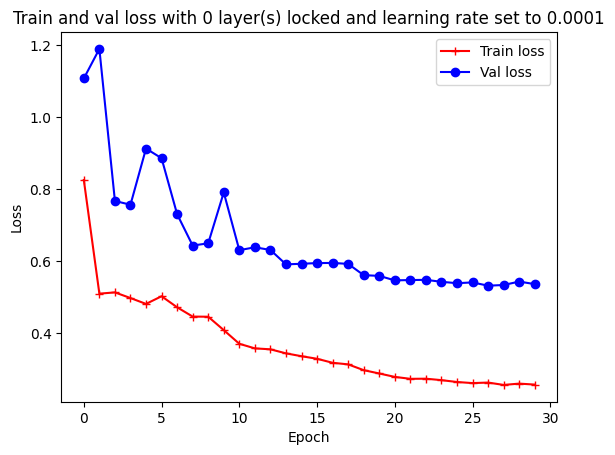

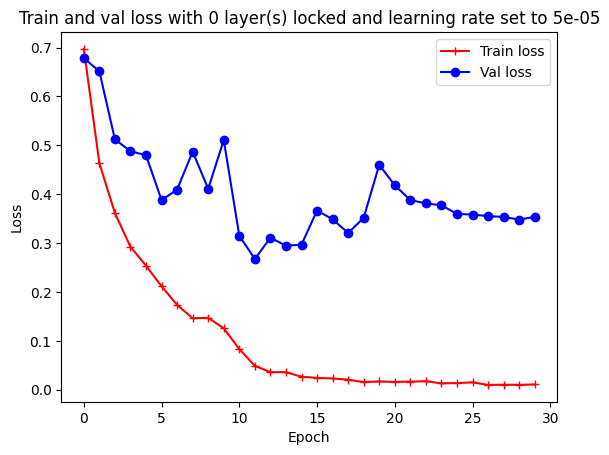

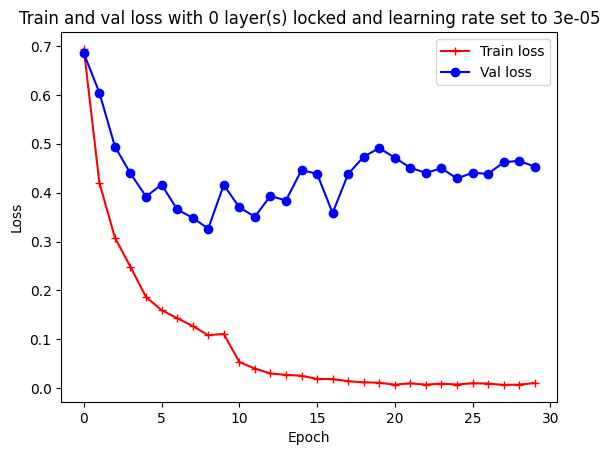

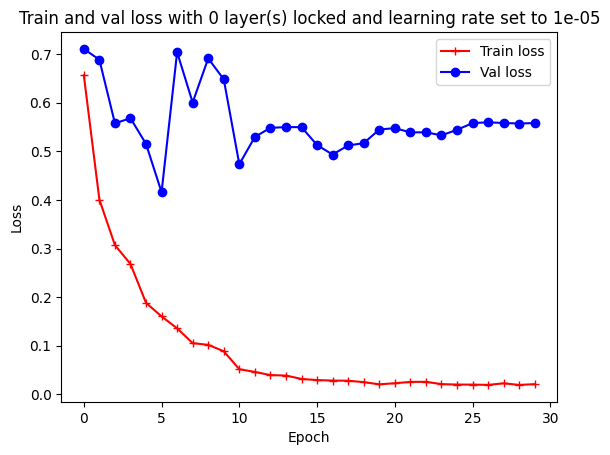

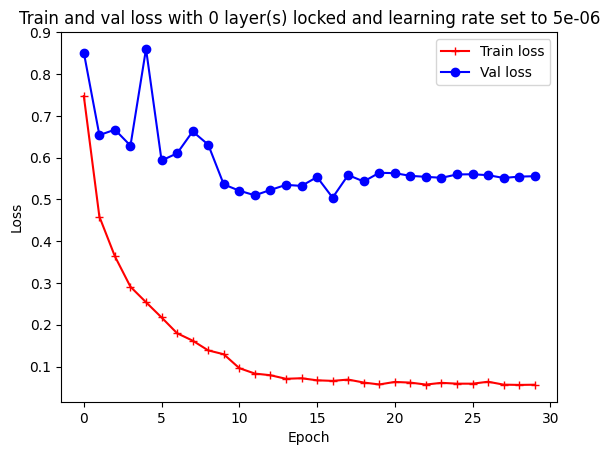

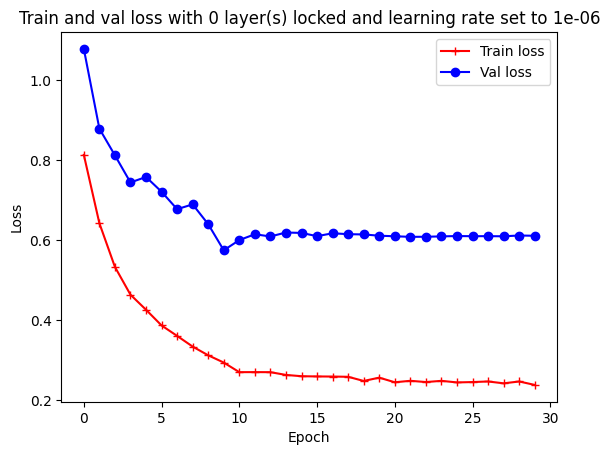

In [15]:
for i in range(6):
    loss_plot(train_loss_list[i], val_loss_list[i], 0, epoch_num, learning_rate[i])

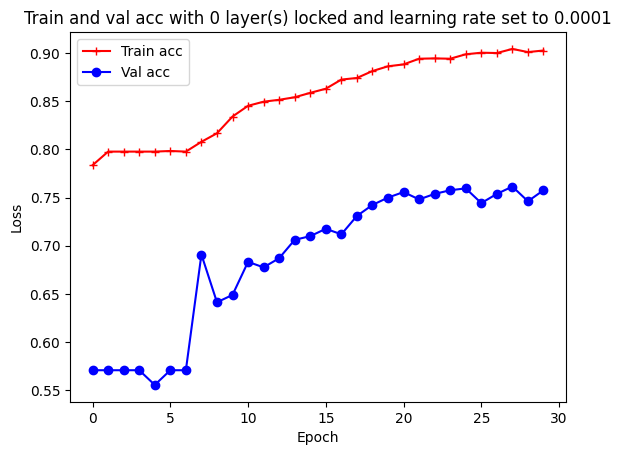

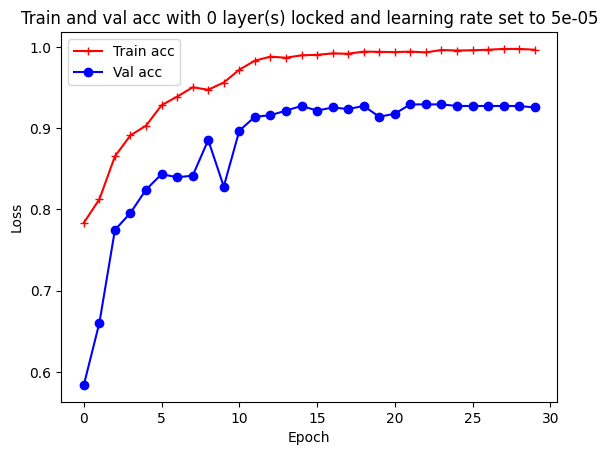

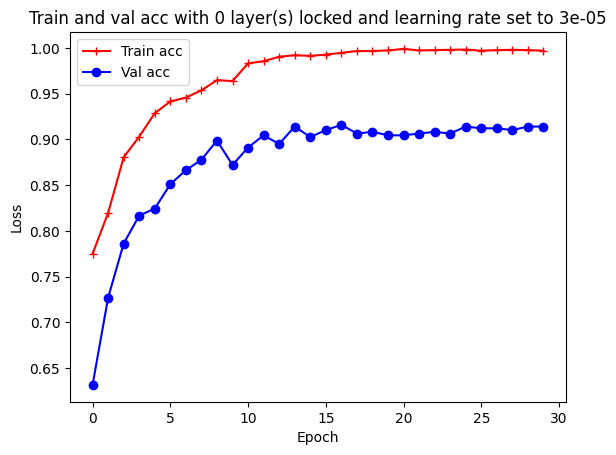

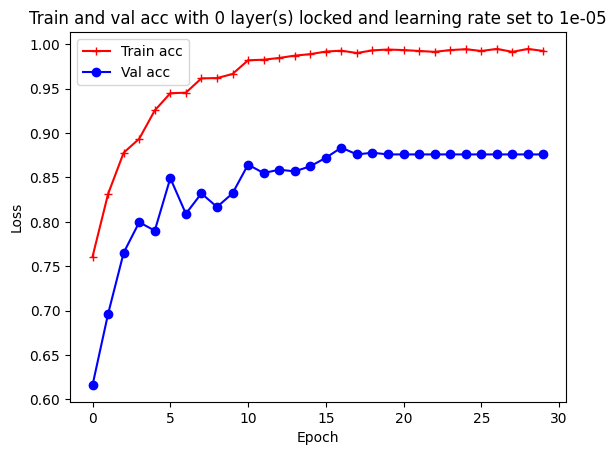

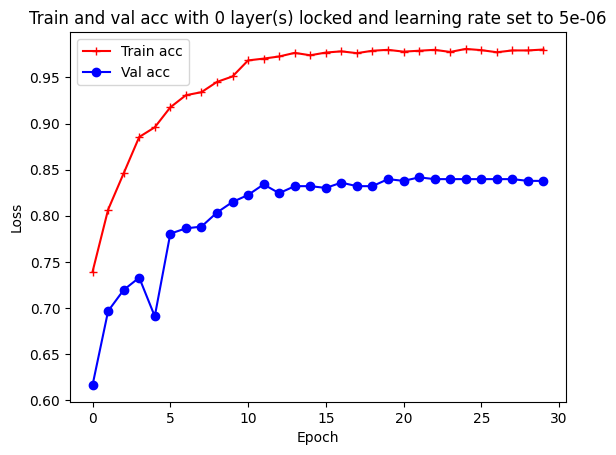

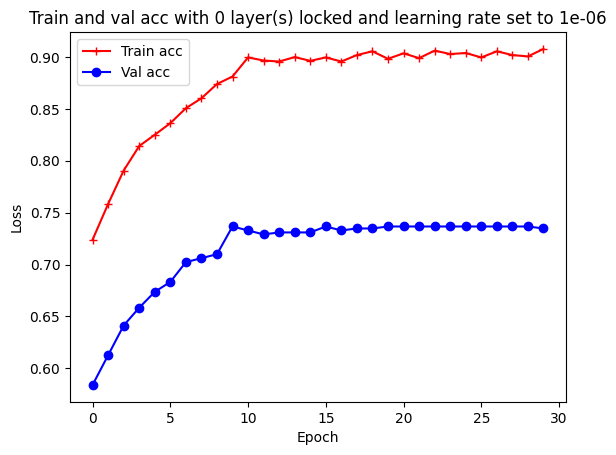

In [16]:
for i in range(6):
    acc_plot(train_acc_list[i], val_acc_list[i], 0, epoch_num, learning_rate[i])